## KFServing Model Explainability

Install the necessary libraries

In [1]:
import os
import sys
import requests
import json
from matplotlib import pyplot as plt
import numpy as np
from aix360.datasets import MNISTDataset
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import time
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Get endpoint, host headers, and load the image from a file or from the MNIST dataset.

In [2]:
print('************************************************************')
print('************************************************************')
print('************************************************************')
print("starting query")

if len(sys.argv) < 3:
    raise Exception("No endpoint specified. ")

endpoint = sys.argv[1]
headers = {
    'Host': sys.argv[2]
}
test_num = 1002
is_file = False
if len(sys.argv) > 3:
    try:
        test_num = int(sys.argv[2])
    except:
        is_file = True

if is_file:
    inputs = open(sys.argv[2])
    inputs = json.load(inputs)
    actual = "unk"
else:
    data = MNISTDataset()
    inputs = data.test_data[test_num]
    labels = data.test_labels[test_num]
    actual = 0
    for x in range(1, len(labels)):
        if labels[x] != 0:
            actual = x
    inputs = gray2rgb(inputs.reshape((-1, 28, 28)))
    inputs = np.reshape(inputs, (28,28,3))
input_image = {"instances": [inputs.tolist()]}

************************************************************
************************************************************
************************************************************
starting query


Display the input image to be used.

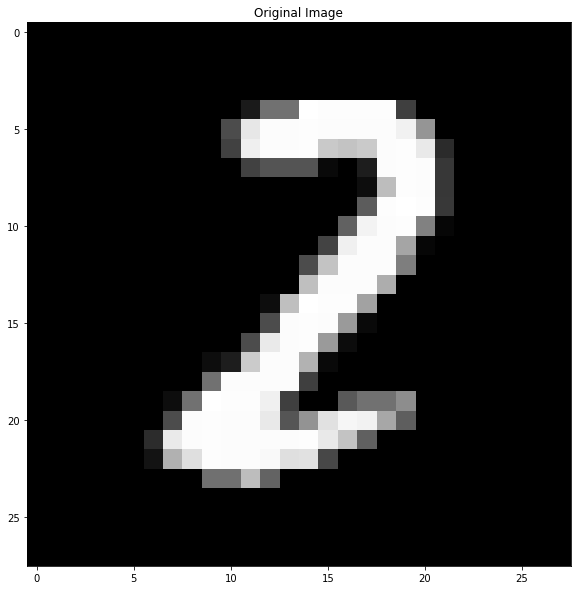

In [3]:
fig0 = (inputs[:,:,0] + 0.5)*255
f, axarr = plt.subplots(1, 1, figsize=(10,10))
axarr.set_title("Original Image")
axarr.imshow(fig0, cmap="gray")
plt.show()

Send the image to the inferenceservice.

In [4]:
print("Sending Explain Query")

x = time.time()

res = requests.post(endpoint, json=input_image, headers=headers)

print("TIME TAKEN: ", time.time() - x)

Sending Explain Query
TIME TAKEN:  1.2478861808776855


Unwrap the response from the inferenceservice and display the explanations.

/usr/local/lib/python3.7/site-packages/skimage/color/colorlabel.py:111: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

<Response [200]>


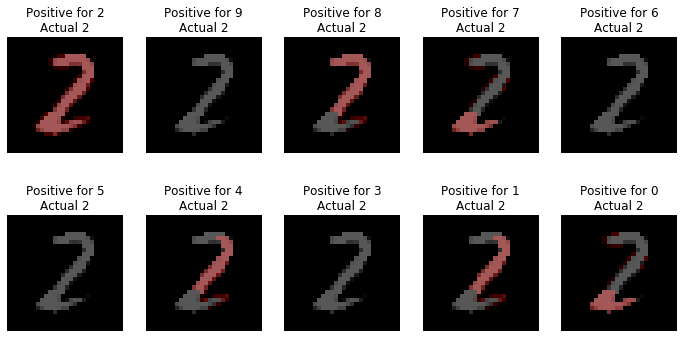

In [5]:
print(res)
if not res.ok:
    res.raise_for_status()
res_json = res.json()
temp = np.array(res_json["explanations"]["temp"])
masks = np.array(res_json["explanations"]["masks"])
top_labels = np.array(res_json["explanations"]["top_labels"])

fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    mask = masks[i]
    c_ax.imshow(label2rgb(mask, temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(top_labels[i], actual))
    c_ax.axis('off')
plt.show()